  # Sentiment Analysis on Coronavirus Tweets
  
                                           Jean-Bertrand Fritzner Leon
                        Institut francophone International(IFI) & Université de La Rochelle

# Introduction
La pandémie du nouveau coronavirus (COVID-19) est un sujet cle de discussion a travers les plateformes 
de médias sociaux en 2020. Les gens utilisent les médias sociaux tels que Twitter pour exprimer leur opinion 
et partager des informations sur un certain nombre de problèmes liés au COVID-19.

*   Dans ce travail, nous allons étudié le sentiment des peuples a travers le monde. Nous choisissons la plateforme 
de médias sociaux Twitter pour notre analyse et étudions les Tweets pour découvrir la perspective sentimentale, 
la perspective émotionnelle. 
*   Au cours de cette pandémie de COVID-19, les chercheurs ont effectué des analyses sur divers ensembles de données 
de médias sociaux concernant le verrouillage et le maintien à la maison. Cependant, dans notre analyse, nous sommes
particulièrement intéressés à analyser le sentiment du public a travers l'epidemie.

# Récupération, Prétraitement et Exploration de données

Importation des bibliotheques, regard sur la structure et lecture de l'ensemble de données

In [21]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import json
import os
from collections import Counter
import datetime as dt

In [23]:
data = pd.read_csv('data/sentiment_analysis_on_coronavirus_tweets_dataset.csv', encoding = 'latin1') # lire le fichier .csv

In [24]:
data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [25]:
data.shape

(41157, 6)

In [26]:
data.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [27]:
data.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Avec Pandas, nous pouvons commencer avec quelques statistiques simples. Les résultats suivants seront dans l'ordre décroissant de sorte que le premier élément soit l'élément le plus fréquent.

In [29]:
sentiment_label = {"Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"}
data.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

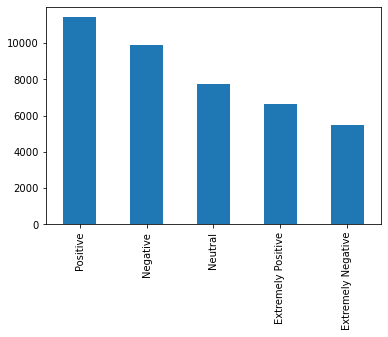

In [30]:
_ = data.Sentiment.value_counts().plot(kind='bar')

# Prétraitement des données
Les tweets contiennent de nombreux caractères inutiles comme du code html, des emojis et des URL. Nous devons nettoyer nos données en supprimant ces caractères avant d'effectuer une analyse des sentiments.

In [31]:
!pip install spacy 
!python -m spacy download en_core_web_md

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\urllib3\connection.py", line 170, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\socket.py", line 745, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\urllib3\connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_

In [32]:
import spacy
import string

nlp = spacy.load("en_core_web_md") # charge le modèle en anglais

spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS) # la liste des mots vides de SpaCy

punctuation = list(string.punctuation) # une liste avec ponctuations

spacy_stopwords[:10], punctuation[:10]

(['before',
  'except',
  'give',
  'these',
  'three',
  'all',
  'from',
  'in',
  'at',
  'never'],
 ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*'])

In [33]:
spacy_stopwords

['before',
 'except',
 'give',
 'these',
 'three',
 'all',
 'from',
 'in',
 'at',
 'never',
 'than',
 'into',
 'there',
 '’d',
 'due',
 'nowhere',
 'anyone',
 'doing',
 'mine',
 'seemed',
 'seeming',
 'whither',
 "'ve",
 'being',
 'why',
 'been',
 'just',
 'even',
 'move',
 'must',
 'them',
 'although',
 'latterly',
 'his',
 'fifteen',
 'well',
 'your',
 '’re',
 'because',
 'whereafter',
 '’ll',
 'himself',
 'us',
 'amongst',
 'the',
 'via',
 'may',
 'were',
 'per',
 'under',
 'thru',
 "n't",
 'therefore',
 'either',
 'once',
 'eleven',
 'me',
 'around',
 'also',
 'regarding',
 'sometimes',
 "'ll",
 'not',
 'become',
 'perhaps',
 'together',
 'this',
 'mostly',
 'few',
 'for',
 'ever',
 'rather',
 'eight',
 'over',
 'sixty',
 'beyond',
 'always',
 'serious',
 'would',
 'further',
 'get',
 'down',
 'formerly',
 'one',
 '‘ll',
 'whereupon',
 'herein',
 'nor',
 'very',
 'onto',
 'who',
 'then',
 'own',
 'already',
 'yourselves',
 'same',
 'to',
 '‘d',
 'he',
 'whom',
 'first',
 'meanwhile

In [34]:
#Suppression de toutes les ponctuations et chiffres
data.OriginalTweet = [re.sub('[^a-zA-Z]', ' ',i) for i in data.OriginalTweet]

#Convertir en minuscules
data.OriginalTweet = [low.lower() for low in data.OriginalTweet]

#Supprimer les Emojis
def preprocess(OriginalTweet):
    emojis = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',OriginalTweet)
    OriginalTweet = re.sub('[\W]+',' ', OriginalTweet.lower()) +\
    ' '.join(emojis).replace('-','')
     
    return OriginalTweet
    
data.OriginalTweet=data.OriginalTweet.apply(preprocess)

#Supprimer les URLs 
data.OriginalTweet = data.OriginalTweet.apply(lambda x: re.sub(r"https\S+", "", str(x)))
data.OriginalTweet.head(10)


0     menyrbie phil gahan chrisitv https t co ifz f...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
5    as news of the region s first confirmed covid ...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didn t buy toilet...
8    due to covid our retail store and classroom in...
9    for corona prevention we should stop to buy th...
Name: OriginalTweet, dtype: object

Après avoir supprimé les caractères non pertinents des tweets, nous supprimerons les mots répétitifs des textes appelés mots vides.

In [35]:
cachedStopWords=set(stopwords.words("english"))
print(cachedStopWords)

{'before', 'these', "couldn't", 'from', 'in', 'all', 'at', 'than', 'into', 'there', 'shouldn', 'doing', "shouldn't", 'being', 'why', 'been', 'just', 'them', 'your', 'his', "weren't", 'because', 'm', 't', 'himself', 'the', 'were', 'under', "aren't", 'once', 'me', 'mightn', 'not', 'hasn', 'this', 'few', 'for', 'o', "wouldn't", 'over', "mustn't", "you'll", 'further', 'down', 'nor', 'very', 'who', 'then', 'yourselves', 'own', 'to', 'same', "didn't", 'he', 'whom', 'will', 'had', 'yours', 'they', 'does', 'more', "shan't", 'was', 'herself', 're', 'couldn', 'we', 'if', 'theirs', "don't", 'both', 'myself', 'each', 's', 'those', 'yourself', "needn't", 'be', 'should', "it's", 'is', 'have', 'other', "mightn't", 'on', 'themselves', 'between', 'up', "she's", 'am', 'of', 'll', 'you', 'here', 'weren', 'so', 'now', 'below', 'above', 'some', 'no', 'her', 'didn', 'i', 'but', 'aren', 'ma', 'd', 'which', 'it', 'and', 'needn', 'most', 'him', 'again', "haven't", 'hers', 'won', 'do', 'a', 'by', 'don', 'off', 

Après avoir supprimé les mots vides, les prochaines étapes effectuées sont la racine et la lemmatisation pour extraire les mots originaux qui sont tweetés par l'utilisateur, puis diviser le texte en mots individuels.

In [36]:
#Supprimer Stop Words
data.OriginalTweet=data.OriginalTweet.apply(lambda tweet: ' '.join([word for word in tweet.split() if word not in cachedStopWords]))

#Stemming
porter = PorterStemmer()
def stemWords(word):
    return porter.stem(word)
        
data["OriginalTweet"] = data["OriginalTweet"].apply(lambda tweet: ' '.join([stemWords(word) for word in tweet.split()]))


In [37]:
#Lemmatization: 
lema = WordNetLemmatizer()
def lemmatizeWords(word):
    return lema.lemmatize(word)
data.OriginalTweet = data.OriginalTweet.apply(lambda tweet: ' '.join([lemmatizeWords(word) for word in tweet.split()]))


#Préparer les mots en divisant le texte
words=[]
words=[word for tweet in data.OriginalTweet for word in tweet.split()]

In [38]:
print(words[0:100])

['menyrbi', 'phil', 'gahan', 'chrisitv', 'http', 'co', 'ifz', 'fan', 'pa', 'http', 'co', 'xx', 'ghgfzcc', 'http', 'co', 'nlzdxno', 'advic', 'talk', 'neighbour', 'famili', 'exchang', 'phone', 'number', 'creat', 'contact', 'list', 'phone', 'number', 'neighbour', 'school', 'employ', 'chemist', 'gp', 'set', 'onlin', 'shop', 'account', 'po', 'adequ', 'suppli', 'regular', 'med', 'order', 'coronaviru', 'australia', 'woolworth', 'give', 'elderli', 'disabl', 'dedic', 'shop', 'hour', 'amid', 'covid', 'outbreak', 'http', 'co', 'binca', 'vp', 'p', 'food', 'stock', 'one', 'empti', 'plea', 'panic', 'enough', 'food', 'everyon', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covid', 'franc', 'covid', 'covid', 'coronaviru', 'confin', 'confinementot', 'confinementgener', 'http', 'co', 'zrlg', 'z', 'j', 'readi', 'go', 'supermarket', 'covid', 'outbreak', 'paranoid', 'food', 'stock', 'litterali', 'empti', 'coronaviru', 'seriou']


# TfidfVectorizer
TfidfVectorizer est une méthode pour transformer le texte en vecteurs de caractéristiques qui peuvent être utilisés comme entrée pour l'estimateur en donnant l'importance du mot dans la phrase.

Il est utilisé pour classer les documents, le classement dans les moteurs de recherche.

*   tf: fréquence du terme (décompte des mots présents dans le document à partir de son propre vocabulaire) 
*   idf: fréquence inverse du document (importance du mot pour chaque document).

**Note :** nous traitons des *n-grames*, donc utilisez le paramètre [`ngram_range`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de la classe [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) lors de son instanciation.

**Note :** pour transformer vos vecteurs résultats (obtenus par appel à `fit_transform`) en des données utilisables dans un `DataFrame`, vous devez utiliser `vectors.toarray()`. À la création de votre `DataFrame`, nommez les colonnes avec le nom des lemmes utilisés (ce sont les *features* de l’opération, vous pouvez les récupérer avec `get_feature_names()`).

**Note :** comment on renverse une matrice ? En demandant sa transposée. Pour la transposée d’un `pd.DataFrame`, on accède simplement l’attribut `T` du `pd.DataFrame`.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Définition du vectoriseur
vect = TfidfVectorizer(ngram_range=(1,1), max_features=100).fit(data.OriginalTweet)

# Transformez le vectoriseur
X_txt = vect.transform(data.OriginalTweet)

# Transformer en un bloc de données
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X.head(10)

,also,amp,busi,buy,chang,close,co,come,compani,consum,coronaviru,could,covid,crisi,custom,day,deliveri,demand,distanc,due,employe,essenti,even,everyon,face,food,get,go,good,govern,groceri,hand,health,help,home,http,impact,increas,keep,know,like,local,lockdown,look,make,mani,market,mask,need,new,oil,one,onlin,order,outbreak,pandem,panic,paper,peopl,plea,price,product,protect,report,retail,safe,sanit,say,see,servic,shelv,shop,social,spread,staff,stay,still,stock,stop,store,supermarket,suppli,take,thank,thing,think,time,today,toilet,toiletpap,uk,use,via,viru,way,week,work,worker,world,would
0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.706180,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.708032,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.455457,0.597012,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.408215,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.519130,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.262413,0.0,0.0,0.0,0.284475,0.0,0.257991,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.263102,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.691044,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.486713,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.103310,0.0,0.0,0.0,0.111995,0.0,0.304707,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.279207,0.0,0.345508,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.103581,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211515,0.0,0.0,0.241104,0.000000,0.000000,0.000000,0.0,0.228059,0.000000,0.000000,0.253931,0.0,0.0,0.0,0.000000,0.000000,0.283008,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.512946,0.0,0.228665,0.000000,0.000000,0.000000,0.000000,0.247025,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.151893,0.0,0.0,0.0,0.164663,0.0,0.149333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.253995,0.0,0.298442,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.152292,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.399999,0.0,0.335307,0.000000,0.000000,0.373346,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.336198,0.000000,0.000000,0.238818,0.000000,0.000000,0.000000,0.410926,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.129623,0.0,0.0,0.0,0.000000,0.0,0.127438,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.216754,0.0,0.000000,0.327819,0.0,0.000000,0.288606,0.0,0.0,0.00000,0.129963,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0

# CountVectorizer

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Définition du vectoriseur
vect = CountVectorizer(ngram_range=(1,2), max_features=100).fit(data.OriginalTweet)

# Transformez le vectoriseur
X_txt = vect.transform(data.OriginalTweet)

# Transformer en un bloc de données
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X.head(10)

,amp,busi,buy,chang,close,co,come,consum,coronaviru,coronaviru covid,coronaviru http,covid,covid coronaviru,covid http,covid pandem,crisi,custom,day,deliveri,demand,due,employe,essenti,even,food,get,go,good,groceri,groceri store,hand,hand sanit,health,help,home,http,http co,impact,increas,keep,know,like,local,lockdown,look,make,mani,market,mask,need,new,oil,one,onlin,onlin shop,order,outbreak,pandem,panic,panic buy,paper,peopl,plea,price,product,protect,retail,sanit,say,see,servic,shelv,shop,social,spread,staff,stay,still,stock,stop,store,supermarket,suppli,take,thank,think,time,today,toilet,toilet paper,toiletpap,uk,use,via,viru,way,week,work,worker,would
0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


# Analyse des sentiments
C'est le processus d'identification et de catégorisation par ordinateur des opinions exprimées dans un texte, en particulier afin de déterminer si l'attitude de l'écrivain envers un sujet, un produit, etc. particulier est positive, négative ou neutre.

- Polarité: à quel point un mot est positif ou négatif. -1 est très négatif. +1 est très positif. 0 est neutre.

### 1- Avec la bibliotheque textblob 

In [41]:
from textblob import TextBlob

pol=[]
for text in data.OriginalTweet:
    blob = TextBlob(text)
    pol.append(blob.sentiment.polarity)
    
data['Polarity']=pol
data.head(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Polarity
0,3799,48751,London,16-03-2020,menyrbi phil gahan chrisitv http co ifz fan pa...,Neutral,0.000000
1,3800,48752,UK,16-03-2020,advic talk neighbour famili exchang phone numb...,Positive,0.000000
2,3801,48753,Vagabonds,16-03-2020,coronaviru australia woolworth give elderli di...,Positive,0.000000
3,3802,48754,NaN,16-03-2020,food stock one empti plea panic enough food ev...,Positive,0.266667
4,3803,48755,NaN,16-03-2020,readi go supermarket covid outbreak paranoid f...,Extremely Negative,0.000000
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,news region first confirm covid case came sull...,Positive,0.256667
6,3805,48757,"35.926541,-78.753267",16-03-2020,cashier groceri store share insight covid prov...,Positive,0.000000
7,3806,48758,Austria,16-03-2020,supermarket today buy toilet paper rebel toile...,Neutral,-0.033333
8,3807,48759,"Atlanta, GA USA",16-03-2020,due covid retail store classroom atlanta open ...,Positive,0.006250
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,corona prevent stop buy thing cash use onlin p...,Negative,0.000000


Nous utiliserons l'analyseur de sentiments Vader pour obtenir la polarité complète des tweets.

In [42]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [43]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = data.OriginalTweet.apply(lambda x: sid.polarity_scores(x))
sentimental_score = pd.DataFrame(list(sentiment_scores))
sentimental_score.tail()

,neg,neu,pos,compound
41152,0.000,1.000,0.000,0.0000
41153,0.375,0.625,0.000,-0.7351
41154,0.106,0.704,0.190,0.2960
41155,0.233,0.526,0.241,0.0258
41156,0.000,0.863,0.137,0.4215


In [44]:
sentimental_score['val'] = sentimental_score['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sentimental_score.head(10)

,neg,neu,pos,compound,val
0,0.000,0.867,0.133,0.3182,positive
1,0.119,0.795,0.086,-0.4588,negative
2,0.000,1.000,0.000,0.0000,neutral
3,0.105,0.730,0.165,0.2263,positive
4,0.194,0.806,0.000,-0.6486,negative
5,0.000,0.761,0.239,0.8316,positive
6,0.000,0.872,0.128,0.2960,positive
7,0.138,0.862,0.000,-0.1531,negative
8,0.000,0.915,0.085,0.3612,positive
9,0.185,0.772,0.042,-0.5719,negative


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

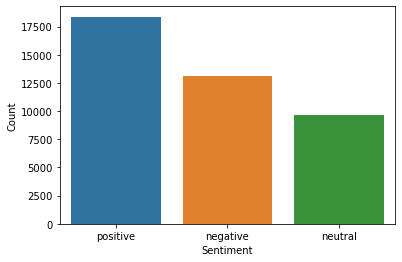

In [45]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score['val']), orient = 'index').reset_index()
sent_count.columns = ['Sentiment', 'Count']

sns.barplot(y="Count", x='Sentiment', data=sent_count)

La majorité des tweets sont de nature positive ou negative avec moins de tweets neutre.

In [46]:
sentiments_time = pd.DataFrame()
sentiments_time['time'] = data['TweetAt']
sentiments_time['polarity'] = sentimental_score['compound']
sentiments_time.index = pd.to_datetime(sentiments_time['time'])

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution des sentiments de Tweet'}, xlabel='polarity', ylabel='frequency'>

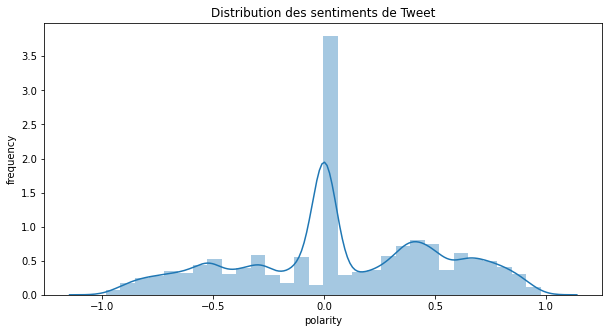

In [47]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title='Distribution des sentiments de Tweet', xlabel='polarity', ylabel='frequency')
sns.distplot(sentiments_time['polarity'], bins=30, ax=ax)

Ce graphique donne la distribution de la polarité des tweets.

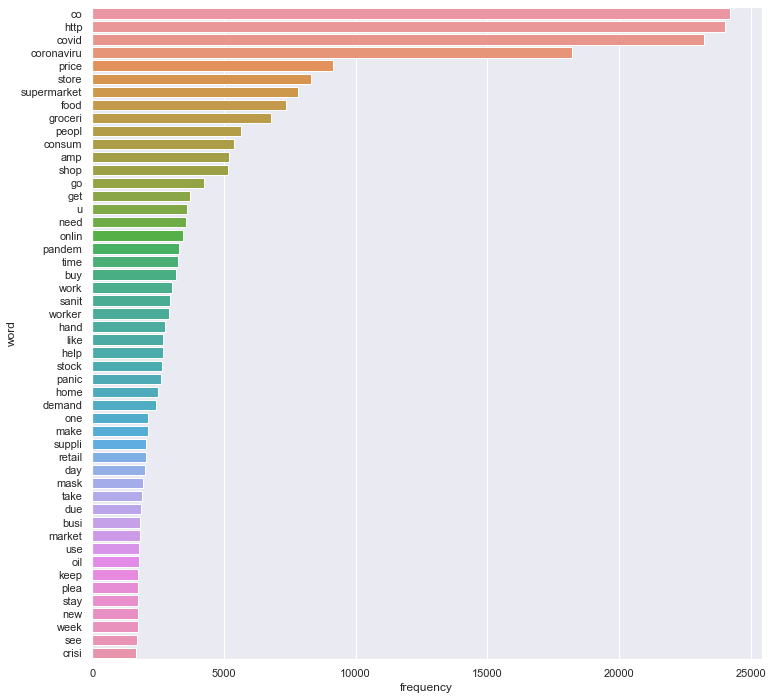

In [48]:
sns.set(style="darkgrid")
counts = Counter(words).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)

Ce graphique donne la fréquence des mots utilisés dans les tweets.

### 2- avec l'apprentissage automatique (machine learning)

**a- Diviser les jeux de données** 

Afin d'entraîner des modèles pour apprentissage automatique et évaluer la performance de ses modèles avec chaque répresentation de mots, nous allons diviser les jeux de données en : entraînement et test.

Afin d'évaluer correctement la performance de chaque modèle, il est très important que les données d'entraînement et de test soient différentes. La bibliothèque <b>sklearn</b> a la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"><i>train_test_split</i></a> qui divise un jeux de données. Le parametre <i>test_size</i> défini la taille du test (pourcentage) dans les jeux de données.

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['OriginalTweet'], data['Sentiment'], test_size=0.2)
len(X_train), len(X_test)

(32925, 8232)

**- MultinomialNB (Naive Bayes)**

L'avantage du classifieur bayésien naïf est qu'il requiert relativement peu de données d'entraînement pour estimer les paramètres nécessaires à la classification, à savoir moyennes et variances des différentes variables.

La bibliothèque sklearn fournit une classe MultinomialNB qui nous permet d'entraîner et tester un modèle à partir d'un jeux de données d'entraînement.

Tout d'abord, nous représentons les documents en utilisant TF-IDF.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train_ = vectorizer.fit_transform(X_train)
X_test_ = vectorizer.transform(X_test)

Utilisons ensuite les données d'entraînement pour entraîner le modèle.

In [51]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
_ = clf.fit(X_train_, y_train)

* [metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) fournit une analyse détaillée par classe: la précision (parmi tous les exemples classés en classe X, combien sont réellement de la classeX) et le rappel (parmi tous les exemples qui sont de la classe X, combien sont classés en classe X) et le F-Score qui est une moyenne harmonique pondérée de la précision et du rappel.

* La précision représente le taux de prédictions qui correspondent exactement aux étiquettes de classes réelles. Précision=$\frac{TP}{TP+FP}$
* Le recall c'est le taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés Recall=$\frac{TP}{TP+FN}$
* Le score F1 est la moyenne harmonique de la précision et du rappel. Il s’agit d’une bonne métrique équilibrée de faux positifs et de faux négatifs. Toutefois, il ne prend pas en compte les vrais négatifs. 
F1-score = 2 x $\frac{précision\ x\ rappel}{précision\ +\ rappel}$

In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_)

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.70      0.01      0.01      1098
Extremely Positive       0.92      0.02      0.03      1317
          Negative       0.39      0.44      0.41      1948
           Neutral       0.84      0.04      0.08      1565
          Positive       0.34      0.89      0.50      2304

          accuracy                           0.36      8232
         macro avg       0.64      0.28      0.21      8232
      weighted avg       0.59      0.36      0.26      8232



* [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) qui donnent les confusions entre les classes.

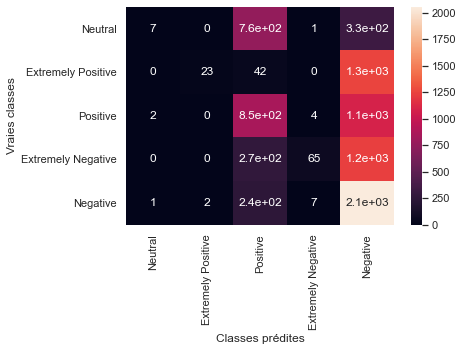

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=set(y_train), yticklabels=set(y_train))
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

**- SVM (Spport Vector Machine)**

Les machines à vecteurs de support (en anglais support vector machine, SVM) sont un ensemble de techniques d'apprentissage supervisé destinées à résoudre des problèmes de discrimination et de régression. 
Ces techniques reposent sur deux idées clés : la notion de marge maximale et la notion de fonction noyau.

In [54]:
from sklearn import svm
from sklearn.svm import SVC
# Divisez les données en un ensemble d'apprentissage et un ensemble de test
# conservation 20% du jeu de données pour l'évaluation
clf = svm.LinearSVC()
_ = clf.fit(X_train_, y_train)
len(X_train), len(X_test)

(32925, 8232)

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.61      0.59      1098
Extremely Positive       0.57      0.66      0.61      1317
          Negative       0.46      0.43      0.45      1948
           Neutral       0.63      0.60      0.61      1565
          Positive       0.48      0.46      0.47      2304

          accuracy                           0.53      8232
         macro avg       0.54      0.55      0.55      8232
      weighted avg       0.53      0.53      0.53      8232



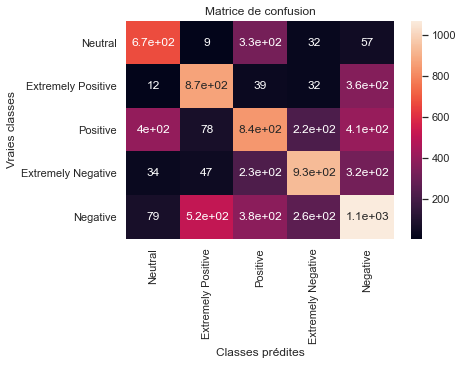

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=set(y_train), yticklabels=set(y_train))
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion')
plt.show()

**- Random forest classifier**

Une forêt aléatoire est un méta-estimateur qui ajuste un certain nombre de classificateurs d'arbres de décision sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler le sur-ajustement.
La taille du sous-échantillon est contrôlée avec le max_samplesparamètre if bootstrap=True(par défaut), sinon l'ensemble de données est utilisé pour construire chaque arbre.

In [57]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
_ = clf.fit(X_train_, y_train)
len(X_train), len(X_test)

(32925, 8232)

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.67      0.32      0.44      1098
Extremely Positive       0.69      0.36      0.47      1317
          Negative       0.46      0.50      0.48      1948
           Neutral       0.54      0.70      0.61      1565
          Positive       0.46      0.57      0.51      2304

          accuracy                           0.51      8232
         macro avg       0.56      0.49      0.50      8232
      weighted avg       0.54      0.51      0.51      8232



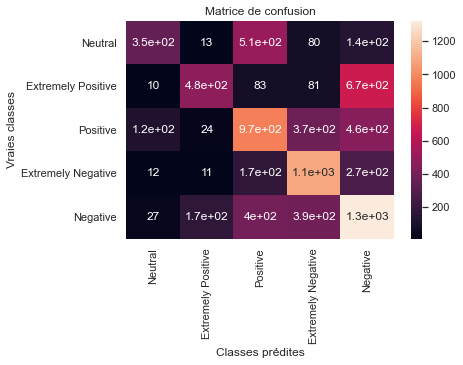

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=set(y_train), yticklabels=set(y_train))
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion')
plt.show()

**- Decision tree classifier**

La structure de l'arbre de décision peut être analysée pour obtenir des informations supplémentaires sur la relation entre les caractéristiques et la cible à prédire.

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
_ = clf.fit(X_train_, y_train)
len(X_train), len(X_test)

(32925, 8232)

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_)
print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

Extremely Negative       0.46      0.33      0.38      1098
Extremely Positive       0.00      0.00      0.00      1317
          Negative       0.00      0.00      0.00      1948
           Neutral       0.00      0.00      0.00      1565
          Positive       0.29      0.95      0.45      2304

          accuracy                           0.31      8232
         macro avg       0.15      0.25      0.17      8232
      weighted avg       0.14      0.31      0.18      8232



C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


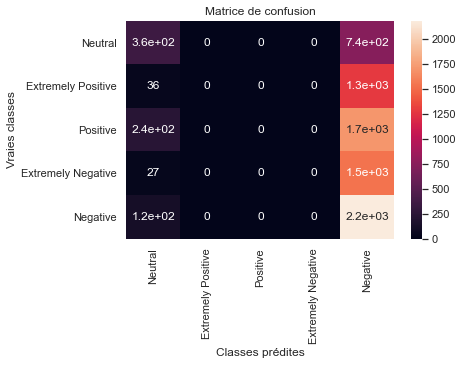

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=set(y_train), yticklabels=set(y_train))
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion')
plt.show()

**- Regression Logistique**

In [63]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
_ = clf.fit(X_train_, y_train)
len(X_train), len(X_test)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(32925, 8232)

In [64]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.48      0.55      1098
Extremely Positive       0.68      0.57      0.62      1317
          Negative       0.50      0.54      0.52      1948
           Neutral       0.63      0.64      0.64      1565
          Positive       0.52      0.59      0.55      2304

          accuracy                           0.57      8232
         macro avg       0.59      0.57      0.58      8232
      weighted avg       0.58      0.57      0.57      8232



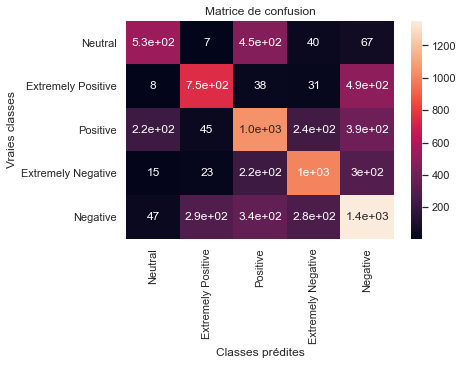

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=set(y_train), yticklabels=set(y_train))
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion')
plt.show()

**- En resume :**

* Le meilleur model c'est la **Regression logistique** avec le vectorizer TFIDF

## proposons maintenant un réseau de neurones pour le sujet que nous abordons

A laide de Keras qui a un intégrateur de mot nous allons entraîné un classificateur de texte neuronal.

In [66]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [68]:
import ast
import os
from nn_utils import TrainingHistory
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import numpy as np
import itertools
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Concatenate

import tensorflow as tf

In [69]:
MAX_FEATURES = 10000 
MAX_TEXT_LENGTH = 1024 
EMBEDDING_SIZE  = 399 
BATCH_SIZE = 16
EPOCHS = 10
VALIDATION_SPLIT = 0.1

In [70]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)

In [71]:
CLASSES_LIST = np.unique(data['Sentiment'])
n_out = len(CLASSES_LIST)

print(CLASSES_LIST, n_out)

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive'] 5


In [72]:
def get_model():

    inputs = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_FEATURES, EMBEDDING_SIZE)(inputs)
    dropout = Dropout(0.5)(model)
    ngram_filters = [1, 2, 3] 
    filters = [300]*3
    convs = []
    for kernel_size, filter_length in zip(ngram_filters, filters):
        conv = Conv1D(filters=filter_length,
                      kernel_size=kernel_size,
                      padding='same',
                      activation='relu')(model)
    
        convs.append(conv)

    model = Concatenate()(convs)
    model = GlobalMaxPooling1D()(model)    

    outputs = Dense(n_out, activation="softmax")(model)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [73]:
def train_fit_predict(model, X_train, X_test, y, history):
    
    model.fit(X_train, y,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(X_test)

In [74]:
# Convertir la chaîne de classe en index (entiers)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)

y_train_encoded = le.transform(y_train) 
y_test_encoded = le.transform(y_test) 
train_y_cat = to_categorical(y_train_encoded, n_out)

In [75]:
y_train_encoded[:5]

array([4, 1, 4, 1, 4])

In [76]:
train_y_cat

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [77]:
# obtenir les données textuelles dans le format correct pour le réseau neuronal
x_vec_train, x_vec_test = get_train_test(X_train, X_test)
len(x_vec_train), len(x_vec_test)

(32925, 8232)

In [ ]:
# définir la topologie du réseau neuronal
model = get_model()

# Définir la procédure d'entrainement
history = TrainingHistory(x_vec_test, y_test_encoded, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1024, 399)    3990000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1024, 300)    120000      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1024, 300)    239700      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
print(classification_report(y_test_encoded, y_predicted, target_names=CLASSES_LIST))
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test_encoded, y_predicted), cmap=plt.cm.Blues, annot=True, fmt='.0f', xticklabels=set(y_train), yticklabels=set(y_train))
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion Apprentissage profonde')
plt.show()